# Decode stimuli from neural activity

In [49]:
#Import packages
import pandas as pd
import h5py
import numpy as np
import scipy as sp
import scipy.signal as sg
import xarray as xr
import os
import matplotlib.pyplot as plt
from matplotlib import patches
import ast
from sklearn import svm
import glob

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

from DR_analysis_utils import Session, makePSTH, make_neuron_time_trials_tensor

%matplotlib notebook

In [10]:
#Set paths to experiment folders
main_path = [
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-07-26_14-09-36_620263\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-07-27_13-57-17_620263\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-08-02_15-40-19_620264\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-09-19_13-48-26_628801\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-09-26_12-48-09_636397\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-09-27_11-37-08_636397\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-12-05_13-08-02_644547\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-12-06_12-35-35_644547\processed",
]

modality = ['vis','vis','aud','vis','aud','aud'] #,'vis','vis','aud','aud']
mouseIDs = ['620263','620263','620264','628801','636397','636397','644547','644547','646318','646318']
exp_nums = [1,2, 1, 1, 1,2, 1,2, 1,2]

## Load a single session

In [275]:
sel_session=4
session=Session(path=main_path[sel_session]) 

In [276]:
# trials table
session.trials

,Unnamed: 0,trialStartFrame,trialStimID,trialstimRewarded,trial_response,trial_rewarded,trial_sound_dur,trial_vis_stim_dur,vis_go_trials,vis_nogo_trials,...,aud_false_alarm_trials,aud_miss_trials,aud_correct_reject_trials,aud_autoreward_trials,catch_trials,catch_resp_trials,trialStimStartFrame,stimStartTime,stimLatency,trial_stim_dur
0,0,0,sound1,sound1,True,True,0.50,0.0,False,False,...,False,False,False,False,False,False,333,1078.764169,0.036729,0.50
1,1,514,sound1,sound1,True,True,0.50,0.0,False,False,...,False,False,False,False,False,False,613,1083.464278,0.066208,0.50
2,2,794,sound1,sound1,True,True,0.50,0.0,False,False,...,False,False,False,False,False,False,886,1088.014237,0.062417,0.50
3,3,1067,sound1,sound1,True,True,0.75,0.0,False,False,...,False,False,False,False,False,False,1288,1094.714154,0.056354,0.75
4,4,1469,sound1,sound1,False,True,0.75,0.0,False,False,...,False,False,False,False,False,False,1561,1099.264126,0.052896,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624,624,214332,sound2,sound1,False,False,1.00,0.0,False,False,...,False,False,True,False,False,False,214425,4662.980218,0.064958,1.00
625,625,214606,sound1,sound1,False,False,1.00,0.0,False,False,...,False,True,False,False,False,False,214698,4667.550836,0.065146,1.00
626,626,214879,sound2,sound1,False,False,1.00,0.0,False,False,...,False,False,True,False,False,False,214998,4672.570521,0.064021,1.00
627,627,215179,sound1,sound1,True,True,0.75,0.0,False,False,...,False,False,False,False,False,False,215273,4677.170603,0.060083,0.75


In [277]:
# add area labels if they exist
tissuecyte_path = r"\\allen\programs\mindscope\workgroups\np-behavior\tissuecyte"

session.units['area']=''
session.good_units['area']=''

if os.path.isdir(os.path.join(tissuecyte_path,mouseIDs[sel_session])):
    for probe in session.units['probe'].unique():
        if type(probe)==str:
            
            channels_table_path=glob.glob(
                os.path.join(tissuecyte_path,mouseIDs[sel_session],
                             '*'+probe+str(exp_nums[sel_session])+'_channels*'))
            if len(channels_table_path)==1:
                channels_table=pd.read_csv(channels_table_path[0])
            else:
                continue

            for ic,chan in channels_table.iterrows():
                chan_units = session.units.query('peak_channel == @chan.channel and \
                                                    probe == @probe').index
                if len(chan_units)>0:
                    if 'region' in chan:
                        assign_area = chan['region']
                    elif 'channel_areas' in chan:
                        assign_area = chan['channel_areas']

                    session.units['area'][chan_units] = assign_area
#                 print(chan_units)
#                 print(chan.channel)
#                 print(chan.channel_areas)


                chan_units = session.good_units.query('peak_channel == @chan.channel and \
                                                        probe == @probe').index
                if len(chan_units)>0:
                    if 'region' in chan:
                        assign_area = chan['region']
                    elif 'channel_areas' in chan:
                        assign_area = chan['channel_areas']
                    session.good_units['area'][chan_units] = assign_area


    session.good_units['area'][session.good_units['area'].isna()]='N/A'
    session.units['area'][session.units['area'].isna()]='N/A'

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.good_units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.good_units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.good_units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.good_units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.good_units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.good_units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.good_units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.good_units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.good_units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.good_units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.good_units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.good_units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.good_units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.good_units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.good_units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.good_units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.good_units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.good_units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.good_units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26576\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

In [278]:
# units table
session.good_units

,quality,cluster_id,probe,firing_rate,presence_ratio,isi_viol,amplitude_cutoff,isolation_distance,l_ratio,d_prime,...,duration,halfwidth,PT_ratio,repolarization_slope,recovery_slope,amplitude,spread,velocity_above,velocity_below,area
id,,,,,,,,,,,,,,,,,,,,,
2209261310001,good,1,A,8.563616,0.99,0.034644,0.013935,17.339936,0.470894,3.401487,...,0.549414,0.219765,0.430590,0.342081,-0.051188,113.367150,80.0,0.899338,NaN,Eth
2209261310003,good,3,A,7.945302,0.99,0.018869,0.007402,9.139305,2.022574,2.017579,...,0.604355,0.288442,0.438177,0.332430,-0.042081,124.129395,80.0,1.749621,NaN,Eth
2209261310014,good,14,A,7.525679,0.97,0.025234,0.001723,27.333665,0.509629,2.310945,...,0.631826,0.206030,0.503734,0.459099,-0.056118,139.669335,50.0,-0.206030,1.373534,LP
2209261310017,good,17,A,4.776417,0.98,0.013920,0.001882,36.567553,0.119668,3.710063,...,0.590620,0.247236,0.417952,0.454822,-0.047667,145.453035,60.0,0.000000,0.686767,LP
2209261310016,good,16,A,11.497588,0.99,0.015616,0.003908,31.393271,0.273165,2.186121,...,0.631826,0.274707,0.552085,0.277221,-0.046357,129.727845,80.0,2.770750,-0.343384,LP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2209261360453,good,453,F,3.403589,0.99,0.013707,0.003239,55.377723,0.029094,4.283019,...,0.727973,0.219765,0.391519,0.265814,-0.032481,107.779230,60.0,1.030151,-0.755444,MOs2/3
2209261360457,good,457,F,5.180793,0.99,0.000000,0.000011,47.534191,0.023087,5.260579,...,0.206030,0.109883,0.567669,0.879840,-0.205788,197.636790,100.0,0.073582,-0.892797,MOs2/3
2209261360459,good,459,F,13.881466,0.99,0.009065,0.081296,85.378194,0.003237,3.713317,...,0.247236,0.109883,0.236587,0.409344,-0.036991,101.147475,50.0,0.343384,0.000000,MOs2/3


In [279]:
session.good_units['area'].value_counts()

CP           94
LP           50
MOp5         39
AUDpo5       39
MOp6a        25
RSPagl5      23
VISp5        19
AUDpo6a      15
MB           15
CA1          14
RSPagl6a     13
POST         12
MOs2/3       11
CA3           9
N/A           8
VISp6a        8
SCig          7
AUDp6a        7
MOp2/3        6
NB            6
RSPagl2/3     5
VISpm5        4
AUDpo4        4
AUDd4         4
VISpm4        3
CA2           3
AUDpo2/3      3
VISal2/3      2
DG-sg         2
Eth           2
AUDd2/3       1
DG-mo         1
VISpm2/3      1
MOp6b         1
Name: area, dtype: int64

In [251]:
# spike times from one unit
session.spike_times[session.units.index[0]]

array([  41.32760934,   42.21184105,   44.75940304, ..., 3814.76647693,
       3814.85157677, 3814.92490997])

In [173]:
# information about each frame
session.frames

,Unnamed: 0,vsyncTimes,frameDelay,runningSpeed
0,0,1073.17296,0.020365,0.000000
1,1,1073.18969,0.020365,13.813190
2,2,1073.20616,0.022530,14.029021
3,3,1073.22287,0.022530,14.892346
4,4,1073.23951,0.022565,15.539839
...,...,...,...,...
215995,215995,4689.22058,0.022460,19.856461
215996,215996,4689.23710,0.022465,20.935616
215997,215997,4689.25374,0.022465,22.014772
215998,215998,4689.27060,0.022410,22.878096


In [280]:
# loop through sessions and make unit xarrays
time_before_flash = 1.5
trial_duration = 3
bin_size = 0.001


# Make tensor (3-D matrix [units,time,trials])
trial_tensor = make_neuron_time_trials_tensor(session.good_units, session.spike_times, 
                                              session.trials,time_before_flash, trial_duration, 
                                              bin_size)

# make xarray
session.trial_da = xr.DataArray(trial_tensor, dims=("unit_id", "time", "trials"), 
                           coords={
                               "unit_id": session.good_units.index.values,
                               "time": np.arange(0, trial_duration, bin_size)-time_before_flash,
                               "trials": session.trials.index.values
                               })

### Try simple decoding of stimuli

In [21]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

In [338]:
# grab data: make these [trials,neurons] matrices based on different time bins:

trial_sel=session.trials.query('trialStimID != "catch"').index
# trial_sel=session.trials.query('trialStimID == "sound1" or \
#                                 trialStimID == "sound2"').index

unit_sel=session.good_units.query('probe == "B"').index
# unit_sel=session.good_units.index

#1: -250:0ms
prestim = session.trial_da.sel(time=slice(-1.5,-1.25),trials=trial_sel,unit_id=unit_sel).mean(dim='time').values
#2: 0:250ms
stim_initial = session.trial_da.sel(time=slice(0,0.25),trials=trial_sel,unit_id=unit_sel).mean(dim='time').values
#3: 250:500ms
stim_steady = session.trial_da.sel(time=slice(0.25,0.5),trials=trial_sel,unit_id=unit_sel).mean(dim='time').values

# grab the stimulus ids
stim_ids = np.vstack(session.trials['trialStimID'][trial_sel].values)

In [339]:
# split train and test data

X = stim_steady[:,:].T
y = stim_ids

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.5)

In [307]:
# prestim.shape

In [340]:
# train the model

# clf = svm.LinearSVC(kernel='linear', C = 1.0)

# clf = svm.LinearSVC(random_state=0, tol=1e-5)
clf = svm.LinearSVC()

clf.fit(xtrain, ytrain)

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [341]:
score = clf.score(xtrain, ytrain)
print("Score: ", score)

Score:  1.0


In [342]:
cv_scores = cross_val_score(clf, xtrain, ytrain, cv=5)
print("CV average score: %.2f" % cv_scores.mean())

CV average score: 0.76


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: Da

In [343]:
ypred = clf.predict(xtest)

cm = confusion_matrix(ytest, ypred)
print(cm)

[[43 35  0  0]
 [43 47  0  0]
 [ 1  0 70  0]
 [ 0  0  0 69]]


In [344]:
cr = classification_report(ytest, ypred)
print(cr)

              precision    recall  f1-score   support

      sound1       0.49      0.55      0.52        78
      sound2       0.57      0.52      0.55        90
        vis1       1.00      0.99      0.99        71
        vis2       1.00      1.00      1.00        69

    accuracy                           0.74       308
   macro avg       0.77      0.76      0.77       308
weighted avg       0.75      0.74      0.74       308



In [353]:
cr_dict=classification_report(ytest, ypred, output_dict=True)
pd.DataFrame.from_dict(cr_dict)

,sound1,sound2,vis1,vis2,accuracy,macro avg,weighted avg
precision,0.494253,0.573171,1.000000,1.0,0.743506,0.766856,0.747198
recall,0.551282,0.522222,0.985915,1.0,0.743506,0.764855,0.743506
f1-score,0.521212,0.546512,0.992908,1.0,0.743506,0.765158,0.744601
support,78.000000,90.000000,71.000000,69.0,0.743506,308.000000,308.000000


In [346]:
#decision function - per trial, distance from hyperplane -- represents confidence in classification
clf.decision_function(xtrain)

array([[ -7.25846336, -10.62844011,   1.30526382,  -1.71568979],
       [  1.00066846,  -1.15679518,  -1.24879777,  -1.43409792],
       [ -8.93186321, -10.20776299,  -1.83821027,   2.30098735],
       ...,
       [ -1.0063136 ,   0.99429935,  -1.54989715,  -1.51063988],
       [ -7.6273039 ,  -8.8332418 ,  -1.94711686,   1.44719523],
       [-10.55357704,  -4.83419469,  -1.12669337,   1.38373829]])

<IPython.core.display.Javascript object>


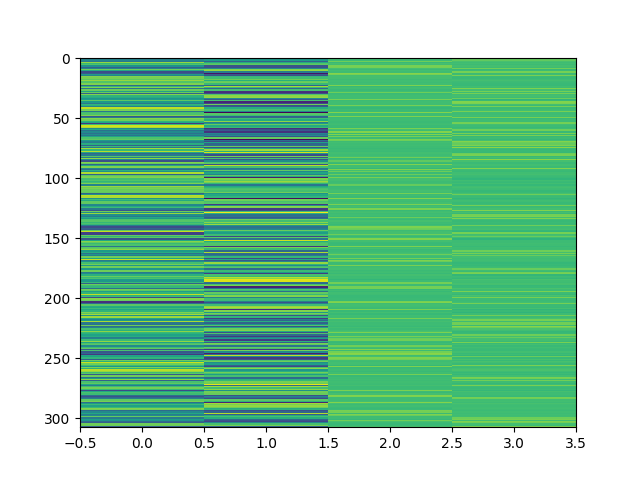

In [348]:
fig,ax=plt.subplots(1,1)
ax.imshow(clf.decision_function(xtest),aspect='auto',interpolation='none')

### decode by area

In [202]:
# session.good_units['area'].value_counts()

In [281]:
#shorten the area names to better lump together units
#get rig of layers and/or sub-areas with dashes
area_short = []
for area in session.good_units['area']:
    if area=='N/A':
        short='N/A'
    elif area[:2]=='CA':
        short=area
    else:
        dig_ind=re.search(r"\d", area)
        dash_ind=re.search(r"-", area)
        if dig_ind!=None:
            short=area[:dig_ind.start()]
        elif dash_ind!=None:
            short=area[:dash_ind.start()]
        else:
            short=area
        
    area_short.append(short)
    
session.good_units['area_short']=area_short

In [282]:
area_counts=session.good_units['area_short'].value_counts()
area_counts[area_counts>25].index

Index(['CP', 'MOp', 'AUDpo', 'LP', 'RSPagl', 'VISp'], dtype='object')

In [292]:
#try more timepoints & split by areas

svc_results={}
binsize=0.02

# grab data: make these [trials,neurons] matrices based on different time bins:
trial_sel=session.trials.query('trialStimID != "catch"').index
area_sel = area_counts[area_counts>25].index

# grab the stimulus ids
stim_ids = np.vstack(session.trials['trialStimID'][trial_sel].values)

time_bins=np.arange(-0.2,0.6,binsize)

for aa in area_sel:
    unit_sel = session.good_units.query('area.str.contains(@aa)').index.values
    svc_results[aa]={}
    for tt,t_start in enumerate(time_bins[:-1]):
        
        sel_data = session.trial_da.sel(time=slice(t_start,time_bins[tt+1]),
                                        trials=trial_sel,unit_id=unit_sel).mean(dim='time').values
        
#     for tt,t_end in enumerate(time_bins[1:]):
        
#         sel_data = session.trial_da.sel(time=slice(time_bins[0],t_end),
#                                         trials=trial_sel,unit_id=unit_sel).mean(dim='time').values
        
        X = sel_data.T
        y = stim_ids

        xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.5)

        clf = svm.LinearSVC()
        clf.fit(xtrain, ytrain)

        ypred = clf.predict(xtest)

        cr_dict=classification_report(ytest, ypred, output_dict=True)
        cr_df=pd.DataFrame.from_dict(cr_dict)

        svc_results[aa][tt]=cr_df
        
        


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: Da

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: Da

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: Da

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: Convergen

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: Convergen

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: Convergen

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: Convergen

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: Convergen

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: Convergen

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: Convergen

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: Da

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: Convergen

In [288]:
# results

In [208]:
# results['MOs'][0]

In [293]:
# make into more plottable format

plot_results={}

timepoints=time_bins[1:]

areas=area_sel

for aa in areas:
    plot_results[aa]={}
#     plot_results[tt]['modality']=modality
    plot_results[aa]['vis']=[]
    plot_results[aa]['aud']=[]
#     for tt,tp in enumerate(timepoints):
#         plot_results[aa][tt]=[]
        

         
# diff table for each timepoint?
# row = session
# columns = ['modality','A_vis','A_aud','B_vis','B_aud','C_vis','C_aud','F_vis','F_aud',]

for aa in areas: #svc_results[ss]['results'].keys():
    if aa in svc_results.keys():
        for tt,tp in enumerate(timepoints):
            vis_perf=(
                np.sum([svc_results[aa][tt]['vis1'][['precision','recall']].values,
                        svc_results[aa][tt]['vis2'][['precision','recall']].values]))/4

            aud_perf=(
                np.sum([svc_results[aa][tt]['sound1'][['precision','recall']].values,
                        svc_results[aa][tt]['sound2'][['precision','recall']].values]))/4


            plot_results[aa]['vis'].append(vis_perf)
            plot_results[aa]['aud'].append(aud_perf)


#     plot_results[tt]=pd.DataFrame.from_dict(plot_results[tt])

In [287]:
# plot_results

<IPython.core.display.Javascript object>


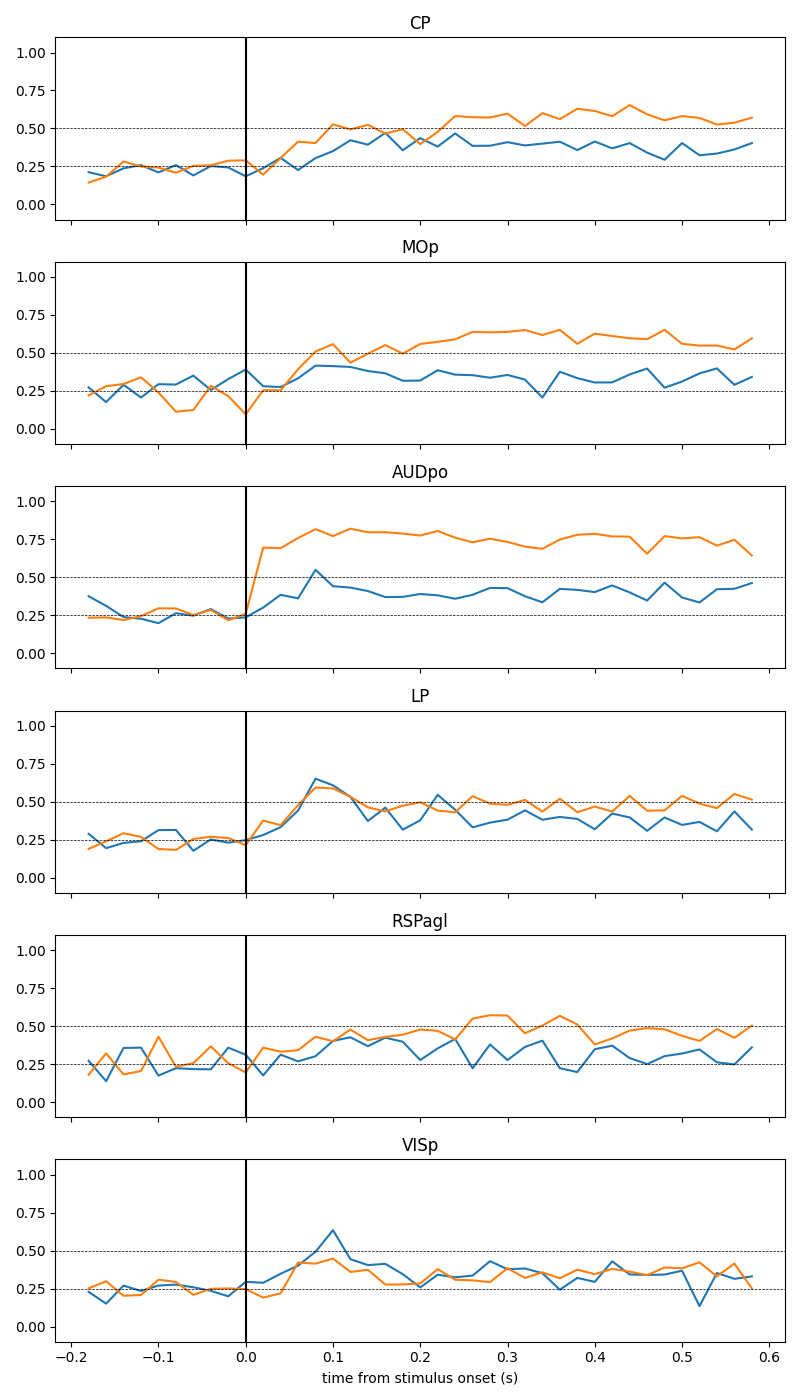

In [294]:
fig,ax=plt.subplots(len(plot_results.keys()),1,figsize=(8,14))

for aa,area in enumerate(plot_results.keys()):
    ax[aa].plot(timepoints,plot_results[area]['vis'])
    ax[aa].plot(timepoints,plot_results[area]['aud'])
    ax[aa].set_ylim([-0.1,1.1])
    ax[aa].axvline(0,color='k')
    ax[aa].axhline(0.25,color='k',linewidth=0.5,linestyle='--')
    ax[aa].axhline(0.5,color='k',linewidth=0.5,linestyle='--')
    ax[aa].set_title(area)
    if aa<len(plot_results.keys())-1:
        ax[aa].set_xticklabels('')

ax[aa].set_xlabel('time from stimulus onset (s)')
fig.tight_layout()